# pailab Specific Setup
This example is taken from [autoencoder](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/autoencoder/convolutional-autoencoder) notebook from the udacity [repository](https://github.com/udacity/deep-learning-v2-pytorch/) and then adapted to work with pailab.
To run it, please make sure that

- PyTorch is installed,
- the path to the file autoenc_conv_pytorch.py (in pailab's example/custom_models directory) is either included in PYTHONPATH environment variable or just set it locally by uncommenting and editingthe following lines

In [1]:
import sys
custom_model_dir = 'C:\\Users\\Anwender\\development\\pailab_oeltz\\examples\\custom_models' # set path to the implemented pytorch autoencoder
if custom_model_dir not in sys.path:
    sys.path.append(custom_model_dir)

We instantiate the repository. Here, we choose simple in memory stores and a simple job runner.

In [2]:
from pailab import RepoInfoKey, MeasureConfiguration, MLRepo, DataSet, MLObjectType, FIRST_VERSION, LAST_VERSION
# setting up the repository
config = {'user': 'test_user',
      'workspace': 'c:/temp',
      'repo_store': 
      {
          'type': 'memory_handler',  
          'config': {}
      },
      'numpy_store':
      {
          'type': 'memory_handler',
          'config':{}
      },
      'job_runner':
      {
          'type': 'simple',
          'config': {
              'throw_job_error': True
          }
      }
    }
ml_repo = MLRepo( user = 'test_user', config=config)


-------
# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset. 

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

<img src='notebook_ims/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

<img src='notebook_ims/denoising.png' width=60%/>

Let's get started by importing our libraries and getting the dataset.

In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

import logging
logging.basicConfig(level=logging.ERROR)

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [4]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)

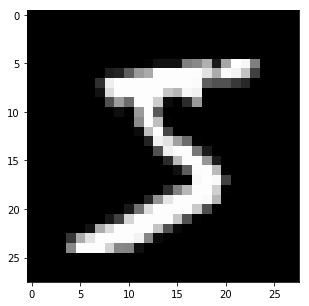

In [6]:
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Convolutional  Autoencoder

#### Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. 

#### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation. A schematic of the network is shown below.

<img src='notebook_ims/conv_enc_1.png' width=640px>

Here our final encoder layer has size 7x7x4 = 196. The original images have size 28x28 = 784, so the encoded vector is 25% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, in fact, you're encouraged to add additional layers to make this representation even smaller! Remember our goal here is to find a small representation of the input data.

### Transpose Convolutions, Decoder

This decoder uses **transposed convolutional** layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d). 

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. 

> We'll show this approach in another notebook, so you can experiment with it and see the difference.


#### TODO: Build the network shown above. 
> Build the encoder out of a series of convolutional and pooling layers. 
> When building the decoder, recall that transpose convolutional layers can upsample an input by a factor of 2 using a stride and kernel_size of 2. 

<img style="float: left;" src='../../../images/bugy_pailab.png' width=5%/> 
**In contrast to the original notebook we have defined the autoencoder outside the notebook in a separate source file: autoenc_conv_pytorch.py which is located in examples/custom_models.**
Also note that we need to transform the data into numpy data to add it to the repo. To add a PyTorch DataSet directly to the repo is subject of future work.

In [7]:
from autoenc_conv_pytorch import ConvAutoencoder
model = ConvAutoencoder()

In [8]:
# transform the pytorch datasets into numpy arrays and add the data to the MLRepo
tuple(train_data[0][0].shape)
train_tmp = np.empty((len(train_data), ) + tuple(train_data[0][0].shape))
for i in range(len(train_data)):
    train_tmp[i] = train_data[i][0]
tuple(test_data[0][0].shape)
test_tmp = np.empty((len(test_data), ) + tuple(test_data[0][0].shape))
for i in range(len(test_data)):
    test_tmp[i] = test_data[i][0]
#now add th raw data as well as the trainign and test data sets to the MLRepo
from pailab import RawData, DataSet
train_raw = RawData(train_tmp, x_coord_names=['image'], repo_info={RepoInfoKey.NAME: 'train_raw'})
test_raw = RawData(test_tmp, x_coord_names=['image'], repo_info={RepoInfoKey.NAME: 'test_raw'})
ml_repo.add([train_raw, test_raw])
train_data_repo = DataSet('train_raw', repo_info={RepoInfoKey.NAME: 'train_data', RepoInfoKey.CATEGORY: MLObjectType.TRAINING_DATA})
test_data_repo = DataSet('test_raw', repo_info={RepoInfoKey.NAME: 'test_data', RepoInfoKey.CATEGORY: MLObjectType.TEST_DATA})
ml_repo.add([train_data_repo, test_data_repo])

{'test_data': '65be55a3-7f2e-11e9-80e7-fc084a6691eb',
 'train_data': '65be55a3-7f2e-11e9-80e7-fc084a6691eb'}

In [9]:
# Add model to the MLRepo.
# The method add_model is a convenience method doign all the work you would need to define a model in pailab:
# adding the training and model parameter, the model definition, the functions for training and evaluation of the model.
import pailab.externals.pytorch_interface as pytorch_interface
from pailab.ml_repo.repo_objects import get_object_from_classname
pytorch_interface.add_model(ml_repo, model, {}, 'conv_autoencoder', batch_size=20, epochs=3,
                           loss='MSE', optimizer='Adam', optim_param={})

# We can check what objects the method added by listing all objects of the repo before and after calling add_model.

---
## Training

<img style="float: left;" src='../../../images/bugy_pailab.png' width=5%/> 
**Since we have defined the model outside of the notebook and the training method is implemented in pailab's PyTorch interface, in contrast to the original notebook we can simply call run_training to start the training.** 

In [10]:
ml_repo.run_training()

('conv_autoencoder/jobs/training', '65c9e922-7f2e-11e9-ae6f-fc084a6691eb')

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. These look a little rough around the edges, likely due to the checkerboard effect we mentioned above that tends to happen with transpose layers.

In [11]:
ml_repo.run_evaluation()

[('conv_autoencoder/model/jobs/eval_job/test_data',
  'dcf05998-7f2e-11e9-a293-fc084a6691eb'),
 ('conv_autoencoder/model/jobs/eval_job/train_data',
  'e1d4b0cd-7f2e-11e9-8d83-fc084a6691eb')]

In [12]:
eval_train = ml_repo.get('conv_autoencoder/eval/train_data', full_object = True)

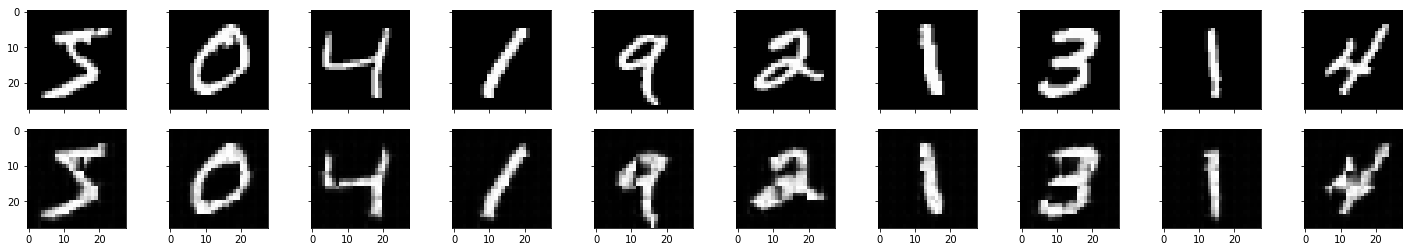

In [13]:
#compare original and autoencoded image
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for i in range(10):
    train_data = ml_repo.get('train_data', full_object = True)
    axes[0,i].imshow(np.squeeze(train_data.x_data[i]), cmap='gray')
    axes[1,i].imshow(np.squeeze(eval_train.x_data[i]), cmap='gray')
